In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pyodbc
database = 'hackathon_danone'
username = 'hack12'
password = 'boA8AKUb54!'
driver= '{SQL SERVER}'
server = '192.168.250.3'

my_engine = create_engine(f"""mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={server}', fast_executemany=True""" )

def db_sql(sql):
    cnxn = pyodbc.connect(f'DRIVER={driver};PORT=1433;SERVER={server};DATABASE={database};UID={username};PWD={password}')
    data = pd.read_sql(sql,cnxn)
    cnxn.close()    
    return data

## Preparing data

### Materials

In [2]:
raw_mat_in = db_sql("SELECT * from dbo.recipe_0_raw_material_in")

raw_mat_used = db_sql("SELECT * from dbo.recipe_0_raw_material_used")

raw_materials = raw_mat_in.merge(raw_mat_used, on=['id', 'process_order_sap3'])

In [3]:
cols = ['fat_pct', 'particles_grp1', 'particles_grp2',
                              'particles_grp3', 'moisture']

In [4]:
for col in cols:
    raw_materials[col] *= raw_materials['usage_pct']

In [5]:
raw_materials = raw_materials.groupby('id').apply(sum)

### Bags

In [19]:
out = db_sql("SELECT * from dbo.recipe_0_out_semi_finished_production")

### Combining

In [35]:
bags = out.set_index("orders_details_id").join(raw_materials)

In [21]:
from sklearn.linear_model import LinearRegression

### Baseline

In [22]:
lr = LinearRegression()

In [27]:
bags.head()

,bigbag_number,bigbag_filling_time_end,bigbag_filling_duration,bigbag_weight,efficiency,class,id,process_order_sap3,fat_pct,particles_grp1,particles_grp2,particles_grp3,moisture,material_code_2,usage_pct
1,1,2018-06-04 19:00:00,100.0,409.0,102.0,optimal,2.0,3.610362e+09,0.060604,0.537341,0.210579,0.233674,11.4533,20297801.0,1.0
1,2,2018-06-04 20:35:00,115.0,460.0,100.0,optimal,2.0,3.610362e+09,0.060604,0.537341,0.210579,0.233674,11.4533,20297801.0,1.0
1,3,2018-06-04 22:15:00,80.0,368.0,115.0,above,2.0,3.610362e+09,0.060604,0.537341,0.210579,0.233674,11.4533,20297801.0,1.0
1,4,2018-06-04 23:35:00,80.0,344.0,107.0,optimal,2.0,3.610362e+09,0.060604,0.537341,0.210579,0.233674,11.4533,20297801.0,1.0
1,5,2018-06-05 01:05:00,90.0,380.0,105.0,optimal,2.0,3.610362e+09,0.060604,0.537341,0.210579,0.233674,11.4533,20297801.0,1.0


In [43]:
cols = ['fat_pct', 'particles_grp1', 'particles_grp2', 'particles_grp3', 'moisture']

In [44]:
lr.fit(bags[cols], bags['bigbag_weight'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
np.sqrt((abs(bags['bigbag_weight'] - (bags['bigbag_weight'].mean())) ** 2).mean())

46.50411254717857

In [48]:
np.sqrt((abs(bags['bigbag_weight'] - lr.predict(bags[cols])) ** 2).mean())

45.211574216958304

### adding drumdrying varibales

In [41]:
dd = db_sql("select * from dbo.recipe_0_processing_details_dd")

In [53]:
bags = bags.reset_index()

In [65]:
bags = bags.sort_values("bigbag_filling_time_end")

In [66]:
dd = dd.sort_values("testing_time")

In [67]:
dd.head()

,orders_details_id,testing_time,steam_preasure,dd_speed,temp_out
0,1,2018-06-04 17:30:00,8.0,7.0,118.0
1,1,2018-06-04 18:30:00,8.0,7.5,118.0
2,1,2018-06-04 19:30:00,8.0,7.5,118.0
3,1,2018-06-04 20:30:00,8.0,7.5,118.0
4,1,2018-06-04 21:30:00,8.0,7.5,118.0


In [71]:
bags = pd.merge_asof(bags, dd, left_on=['bigbag_filling_time_end'],
                     right_on=['testing_time']).query("index == orders_details_id")

In [76]:
cols_to_fit = ['steam_preasure', 'dd_speed', 'temp_out']

In [82]:
bags = bags.dropna(subset=['efficiency'])

In [85]:
lr.fit(bags[cols_to_fit], bags['bigbag_weight'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
np.sqrt((abs(bags['bigbag_weight'] - lr.predict(bags[cols_to_fit])) ** 2).mean())

43.35048363709463

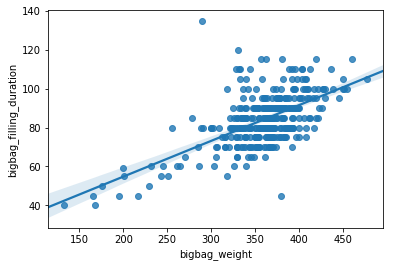

In [91]:
sns.regplot(bags['bigbag_weight'], bags['bigbag_filling_duration'])

In [94]:
bags

,index,bigbag_number,bigbag_filling_time_end,bigbag_filling_duration,bigbag_weight,efficiency,class,id,process_order_sap3,fat_pct,...,particles_grp2,particles_grp3,moisture,material_code_2,usage_pct,orders_details_id,testing_time,steam_preasure,dd_speed,temp_out
0,1,1,2018-06-04 19:00:00,100.0,409.0,102.0,optimal,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-04 18:30:00.000,8.0,7.5,118.0
1,1,2,2018-06-04 20:35:00,115.0,460.0,100.0,optimal,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-04 20:30:00.000,8.0,7.5,118.0
2,1,3,2018-06-04 22:15:00,80.0,368.0,115.0,above,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-04 21:30:00.000,8.0,7.5,118.0
3,1,4,2018-06-04 23:35:00,80.0,344.0,107.0,optimal,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-04 23:30:00.000,8.0,8.5,113.0
4,1,5,2018-06-05 01:05:00,90.0,380.0,105.0,optimal,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 00:30:00.000,8.2,8.5,112.0
5,1,6,2018-06-05 02:35:00,90.0,374.0,104.0,optimal,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 02:30:00.000,8.2,8.5,112.0
6,1,7,2018-06-05 04:05:00,90.0,325.0,90.0,below,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 03:30:00.000,8.2,8.5,113.0
7,1,8,2018-06-05 05:25:00,80.0,302.0,94.0,below,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 04:30:00.000,8.2,9.0,113.0
8,1,9,2018-06-05 06:50:00,85.0,278.0,81.0,below,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 06:30:00.000,8.2,9.0,112.0
9,1,10,2018-06-05 10:40:00,105.0,358.0,85.0,below,2.0,3.610362e+09,0.060604,...,0.210579,0.233674,11.4533,20297801.0,1.0,1,2018-06-05 10:30:00.000,8.2,10.5,112.0
